# Fluidinámica computacional (Sesión 01)

<img src="figures/LogoCinvestav.png" style="width:330px;height:100px" title="Cinvestav">

**CINVESTAV Unidad Saltillo**

**Programa de Maestría en Ciencias en Ingeniería Metalúrgica**

Dr. Edgar Ivan Castro Cedeño


Enero - Junio 2025

Contacto:
[edgar.castro@cinvestav.mx](mailto:edgar.castro@cinvestav.mx)

In [101]:
using CSV
using DataFrames
using Plots
using LaTeXStrings
using Integrals

# Tarea

## 1. Curvas RTD

Utilizando los resultados de simulación, trace las curvas $F$ vs $\theta$, y $C$ vs $\theta$ correspondientes.

- Calcule las variables adimensionales requeridas, $\theta$, $F$, y $C$.

- Trace las curvas $F$ vs $\theta$, y $C$ vs $\theta$ correspondientes.

- Comente sobre las curvas, comparando su comportamiento contra las curvas para flujo en reactores idealizados que se muestran debajo. 

<center>

<img src="figures/images/idealFCurves.png" style="width:400px" title="F vs theta">

***Figura 01. Curvas F para flujo en reactores idealizados.***

</center>

<center>

<img src="figures/images/idealCCurves.png" style="width:400px" title="C vs theta">

***Figura 02. Curvas C para flujo en reactores idealizados.***

</center>

### Leer datos de concentración de trazador

In [52]:
# load data of tracer concentration 
path = "figures/openFoam/scalarValueAtOutlet.dat"
df = CSV.read(path, DataFrame, header=5, )

# modify the column names so they are more "friendly"
println("previous column names: $(names(df))")
rename!(df,:"# Time          " => :t)
rename!(df,:"areaAverage(T)" => :c)
println("new column names: $(names(df))")

previous column names: ["# Time          ", "areaAverage(T)"]
new column names: ["t", "c"]


### Estimación de variables adimensionales

#### tiempo, $\theta$

In [85]:
# add a column with dimensionless time (theta)
tr = 280.0 # theoretical residence time, [s]
df.θ = df.t / tr;

#### concentración, $F$

In [54]:
# add column with dimensionless concentration F
cᵢ = 1 # tracer concentration at entrance
df.F = df.c / cᵢ;

#### concentración, $C$

In [69]:
## Estimation of gradients with different implementations

"""
backwardDiff
"""
function backwardDiff(x, y)
    grads = zeros(size(x))
    for i in 1:length(grads)
        if i == 1
            grads[i] = (y[i+1] - y[i]) / (x[i+1] - x[i])
        else
            grads[i] = (y[i] - y[i-1]) / (x[i] - x[i-1])
        end
    end
    return grads
end

"""
forwardDiff
"""
function forwardDiff(x, y)
    grads = zeros(size(x))
    for i in 1:length(grads)
        if i == length(grads)
            grads[i] = (y[i] - y[i-1]) / (x[i] - x[i-1])
        else
            grads[i] = (y[i+1] - y[i]) / (x[i+1] - x[i])
        end
    end
    return grads
end

"""
centralDiff
"""
function centralDiff(x, y)
    grads = zeros(size(x))
    for i in 1:length(grads)
        if i == 1
            grads[i] = (y[i+1] - y[i]) / (x[i+1] - x[i])
        elseif i == length(grads)
            grads[i] = (y[i] - y[i-1]) / (x[i] - x[i-1])
        else
            grads[i] = (y[i+1] - y[i-1]) / (x[i+1] - x[i-1])
        end
    end
    return grads
end

centralDiff

In [96]:
# add column with dimensionless concentration C
#df.C = backwardDiff(df.θ, df.F);
#df.C = forwardDiff(df.θ, df.F);
df.C = centralDiff(df.θ, df.F);

### Gráficos con comentarios

#### Curva $F$ vs $\theta$

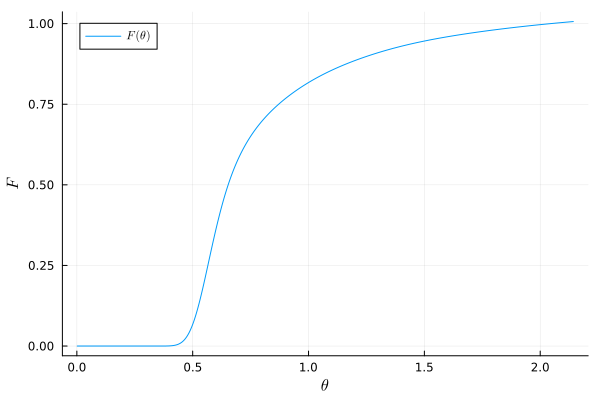

In [73]:
plot(df.θ, df.F, label=L"F(\theta)")
xlabel!(L"$\theta$")
ylabel!(L"F")

Al comparar la curva $F(\theta)$ contra los casos idealizados de flujo pistón y flujo en un reactor perfectamente agitado se tiene que:

- La curva comienza a crecer hasta que cierto tiempo de latencia (en este caso $\theta \approx 0.5$) ha transcurrido. Esta característica se comparte con el flujo pistón.

- Después del crecimiento "subito" de la curva, la curva exhibe un crecimiento hacia un valor asintótico de uno. Esta característica se comparte con el flujo perfectamente agitado.

#### Curva $C$ vs $\theta$

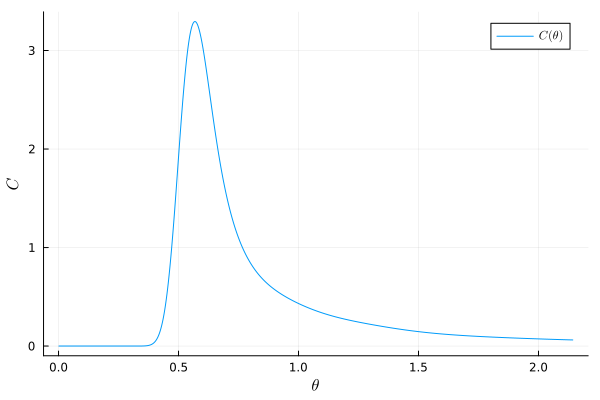

In [190]:
plot(df.θ, df.C, label=L"C(\theta)")
xlabel!(L"$\theta$")
ylabel!(L"C")

Al comparar la curva $C(\theta)$ contra los casos idealizados de flujo pistón y flujo en un reactor perfectamente agitado se tiene que:

- La curva comienza a crecer hasta que cierto tiempo de latencia (en este caso $\theta \approx 0.5$) ha transcurrido. Esta característica se comparte con el flujo pistón.

- Después del crecimiento "subito" de la curva, la curva exhibe una disminuación hacia el valor asintótico de cero. Esta característica se comparte con el flujo perfectamente agitado.

## 2. Fracciones volumétricas de zonas en el reactor

Estime la fracción de diferentes zonas en el reactor:

- Flujo pistón disperso.

- Flujo mixto.

- Zona muerta



### tiempos de interés

**1. tiempo de residencia teórico:**

```math
t_r = \frac{\bar{V}}{\dot{v}}
```

In [127]:
V = 3.5 * 0.8 * 0.1 # volumen del reactor, [m3]
v = 0.1 * 0.1 * 0.1 # flujo volumétrico en el reactor, [m3.s-1]
tr = V/v
println("tᵣ = $(round(tr, digits=2)) [s]")

tᵣ = 280.0 [s]


**2. tiempo de residencia promedio:**

```math
\bar{t} = \frac{\int_0^{2t_r} t C(t) dt}{\int_0^{2t_r} C(t) dt}
```

In [168]:
df[1120, :t] # index in dataframe where t= 2 tr.
twoThetaThreshold = 2*tr
twoThetaIndex = findfirst(x -> x >= (twoThetaThreshold), df.t)
println("2tᵣ = $(round(df.t[twoThetaIndex], digits=2)) [s]")
println("index: $(twoThetaIndex)")

2tᵣ = 560.0 [s]
index: 1120


In [177]:
# recortando datos (clipping)
t = df.t[1:twoThetaIndex]
C = df.C[1:twoThetaIndex]

# numerador
y = @. t * C
x = t
problem = SampledIntegralProblem(y, x)
method = TrapezoidalRule()
num = solve(problem, method)

# denominador
y = C
x = t
problem = SampledIntegralProblem(y, x)
method = TrapezoidalRule()
den = solve(problem, method)

# tiempo de residencia promedio
tavg = num.u / den.u
println("̄t = $(round(tavg, digits=2)) [s]")


̄t = 216.71 [s]


**3. tiempo de residencia mínimo:**

In [171]:
minThreshold = 1e-1
minIndex = findfirst(x -> x > (minThreshold), C)
tmin = df.t[minIndex]
println("t(min) = $(round(tmin, digits=2)) [s]")
println("index: $(minIndex)")

t(min) = 116.5 [s]
index: 233


**4. tiempo de residencia máximo:**

In [176]:
Cmax, maxIndex = findmax(C)
tmax = df.t[maxIndex] 
println("t(max) = $(round(tmax, digits=2)) [s]")
println("C(max) = $(round(Cmax, digits=2)) [ ]")
println("index: $(maxIndex)")

t(max) = 159.0 [s]
C(max) = 3.29 [ ]
index: 318


### tiempos adimensionales

**1. tiempo de residencia adimensional**

```math
\theta = \frac{t}{t_r}
```

In [185]:
θ = @. t / tr;
println("theta(theoretical) = $(round(tr/tr, digits=4))")

theta(theoretical) = 1.0


**2. tiempo de residencia promedio adimensional:**

```math
\bar{\theta} = \frac{\bar{t}}{t_r}
```

In [184]:
θavg = @. tavg / tr;
println("theta(avg) = $(round(θavg, digits=4))")

theta(avg) = 0.7739


**3. tiempo de residencia mínimo:**

```math
\theta_{min} = \frac{t_{min}}{t_r}
```

In [187]:
θmin = @. tmin / tr;
println("theta(min) = $(round(θmin, digits=4))")

theta(min) = 0.4161


**3. tiempo de residencia máximo:**

```math
\theta_{max} = \frac{t_{max}}{t_r}
```

In [188]:
θmax = @. tmax / tr;
println("theta(max) = $(round(θmax, digits=4))")

theta(max) = 0.5679


### Estimación de fracciones volumétricas del reactor

#### Zona con flujo pistón disperso

```math
\frac{V_{dp}}{\bar{V}} = \frac{\theta_{min} + \theta_{max}}{2}
```

In [227]:
V = 3.5 * 0.8 * 0.1 # volumen del reactor, [m3]
Vdp_V = 0.5 * (θmin + θmax);

#### Zona con flujo muerto

```math
\frac{V_d}{\bar{V}} = 1 - \left[\sum_{\theta=0}^{\theta=2} C(\theta)\,\Delta\theta \right] \cdot \bar{\theta}
```

In [228]:
Δθ = forwardDiff(collect(1:1:length(θ)), θ);
Vd_V = 1 - (sum(@. (C * Δθ))) * θavg;

#### Zona con flujo mixto

```math
\frac{V_m}{V} = 1 - \frac{V_{dp}}{V} - \frac{V_{d}}{V}
```

In [229]:
Vm_V = 1 - Vdp_V - Vd_V;

#### Repartición de zonas

In [231]:
println("REPARTICION VOLUMETRICA DE ZONAS:")
println("pistón disperso: $(round(Vdp_V, digits=4))")
println("flujo mixto    : $(round(Vm_V, digits=4))")
println("zonas muertas  : $(round(Vd_V, digits=4))")

REPARTICION VOLUMETRICA DE ZONAS:
pistón disperso: 0.492
flujo mixto    : 0.2796
zonas muertas  : 0.2285
